In [1]:
%config Completer.use_jedi = False

In [2]:
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import pymc3 as pm

matplotlib.rc('font', family='Malgun Gothic')
figsize(14, 8)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 2.2 모델링 방법
- 베이지안 모델링을 처음 시작할 때 데이터가 어떻게 만들어졌는지를 생각해보는 것이 좋음.
- 데이터셋을 어떻게 다시 만들지 생각해보자
    - `1.` '개수 데이터'를 나타내는 최고의 확률 변수는 무엇인가?를 생각함. 포아송분포는 개수 데이터를 잘 표현하므로 좋은 후보. 그래서 포아송분포에서 표본으로 얻은 문자 메세지 개수를 모델링함
    - `2.` '문자 메세지가 포아송 분포를 따른다고 가정'하면 포아송분포를 위해 필요한 것은 무엇인가?를 생각함. 포아송분포는 모수 $lambda$를 가짐
    - `3.` $lambda$를 모름. $lambda$가 또한 두 개 있다고 의심하는 중. 하나는 초기 행동에 대한 것. 나머지 하나는 사후 행동에 관한 것. 행동이 언제 바뀌는지는 모르지만, 바뀌는 시점을 변환점 $\tau$라고 부름
    - `4.` 두 $lambda$에 대한 바람직한 확률분포는 무엇인가? 지수분포는 양의 실수에 확률을 부여하므로 적합한 분포. 지수분포는 $\alpha$라고 부르는 모수를 가짐(hyperparamter)
    - `5.` 모수 $\alpha$가 무엇인지 모름. 이 시점에서 어떤 분포를 $\alpha$에 계속 부여하지만, 알지 못하는 수준에 이르면 일단 중단하는 것이 좋음.
        - $lambda$에 대한 사전 믿음을 가지고 있는 반면, $\alpha$에 대한 믿음은 부족함. 따라서 여기서 모델링을 중단하는 것이 최선
        - 그럼 적합한 $\alpha$값은 무엇일까? ($lambda$ 값들이 10~30 사이일 것이라고 생각할 때)만약 $\alpha$값을 낮게 설정한다면(높은 값에는 더 큰 확률) prior belief를 충분히 반영하지 못하는 것. 마찬가지로 $\alpha$값이 너무 높은것 또한 prior belief를 반영하지 못함.
        - $\alpha$에 $lambda$에 대한 우리의 믿음을 반영하려면 주어진 $\alpha$ 내에서 $lambda$의 평균이 우리가 관측한 평균과 같도록 설정하는 것이 좋음.
    - `6.` $\tau$가 언제 일어났는지에 대한 전문적인 견해가 없으므로, $\tau$가 이산균등분포에서 나왔다고 가정할 것

- 아래 그림에서 이를 시각화 한 모습을 볼 수 있음. 화살표는 부모-자식 관계를 의미함


![](https://camo.githubusercontent.com/a6d43dac555c3053b2c256d0a6b8ee4befcd7ab25c601df895878140a4e5fb06/687474703a2f2f692e696d6775722e636f6d2f374a33306f43472e706e67)

### 2.2.1 재해석
- 스토리를 재해석하여 새로운 데이터셋을 만들 수 있음. 예를 들어, 앞의 6단계를 반대로 뒤집으면 데이터셋의 실현 가능성을 시뮬레이션 가능함.

1. DiscreteUniform(0, 80)에서 표본을 추출하여 사용자의 행동 변화 시점을 명시함

In [3]:
tau = np.random.randint(0, 80)
tau

74

2. $Exp(\alpha)$ 분포에서 $\lambda_1$과 $\lambda_2$를 뽑는다

In [4]:
alpha = 1/20
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)

In [5]:
lambda_1, lambda_2

(1.9222206200980654, 6.649834474221955)

3. $\tau$ 이전 며칠 동안 $\lambda=\lambda_1$에서 샘플링, $\tau$ 이후 $\lambda=\lambda_2$에서 샘플링

In [6]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

In [7]:
data

array([ 2,  1,  0,  3,  4,  2,  2,  4,  2,  1,  1,  2,  2,  4,  1,  2,  1,
        3,  0,  4,  0,  1,  3,  4,  0,  1,  2,  1,  3,  1,  0,  1,  1,  0,
        0,  0,  2,  5,  1,  3,  2,  2,  1,  2,  1,  3,  1,  1,  1,  0,  3,
        3,  2,  2,  1,  5,  2,  1,  1,  2,  1,  2,  1,  0,  3,  0,  0,  3,
        1,  3,  4,  3,  5,  2,  5,  5,  3,  4, 13,  8])

4. 그리기

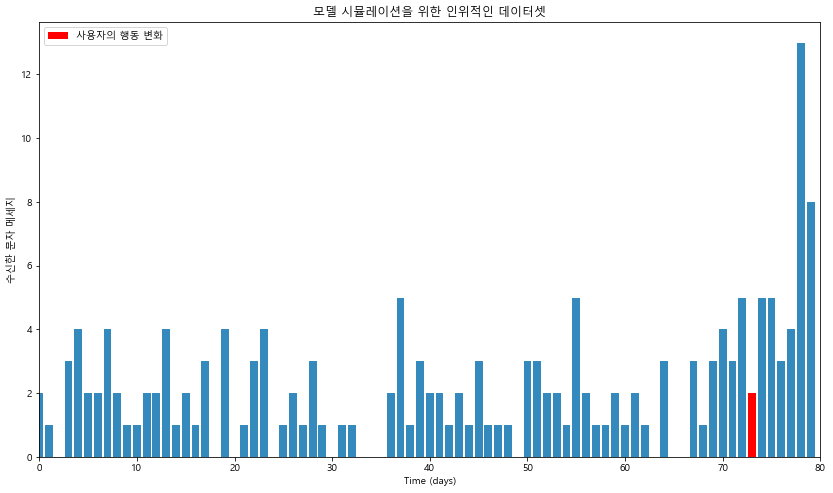

In [8]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label="사용자의 행동 변화")
plt.xlabel("Time (days)")
plt.ylabel("수신한 문자 메세지")
plt.title("모델 시뮬레이션을 위한 인위적인 데이터셋")
plt.xlim(0, 80)
plt.legend();

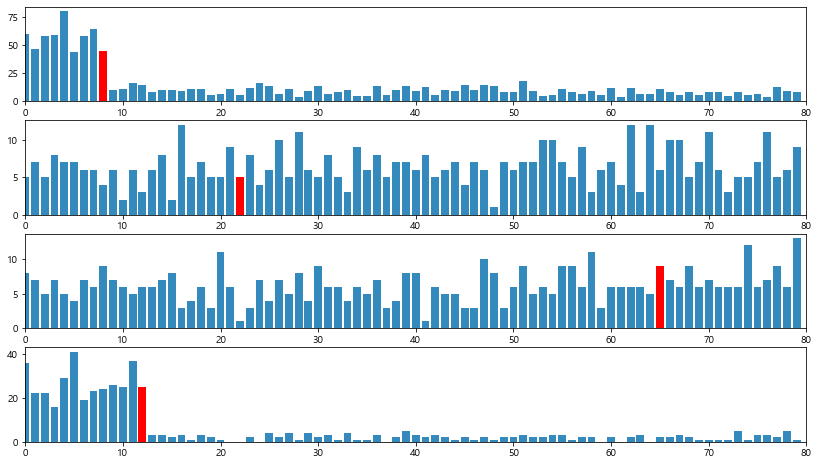

In [9]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

# figsize(12.5, 5)
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

### 2.2.2. 베이지안 A/B 테스트

- A/B 테스트의 핵심은 그룹 간의 차이점이 단 하나뿐이라는 점. 따라서 측정값의 변화가 바로 차이로 연결될 수 있음
- 사후실험분석은 보통 평균차이검정이나 비율차이검정과 같은 가설검정을 사용하여 진행하나, 베이지안적인 접근으로도 자연스럽게 해결 가능


### 2.2.3. 간단한 예제(웹 개발)
- A 사이트 분석에 초점을 맞춤. A 사이트에 노출된 사용자가 궁극적으로 전환할 어떤 확률 $P_A$가 있다고 가정. 이것이 A 사이트의 진정한 효율성. 현재는 알지 못함
- A 사이트가 N명에게 노출되었고, n명이 전환했다고 가정. 성급하게 $P_A=\frac n N$이라는 결론을 내릴 수도 있음.
- 그러나 관측된 빈도 $\frac n N$이 반드시 $P_A$와 같은 것은 아님. `관측빈도`와 `실제빈도`간에는 차이가 있음.
- 실제 빈도는 사건이 일어날 확률로 해석할 수 있으며, 아래와 같은 사건의 실제 빈도를 알아야 함
    - 구매를 하는 사용자의 비율
    - 모집단의 어떤 특정한 비율
    - 고양이를 키우는 인터넷 사용자 비율
    - 내일 비가 내릴 확률
    - ....
- 노이즈와 복잡성때문에 실제 빈도를 알지 못하고 관측된 데이터로 실제 빈도를 추론해야 함.
- 베이지안 통계를 사용하여 적절한 사전확률 및 관측된 데이터를 사용하여 실제 빈도의 추정 값을 추론
- 전환율 예제의 경우, 알고 있는 N(총 방문자 수)과 n(전환한 사람 수)을 사용하여 진정한 전환 빈도 $P_A$가 얼마인지 추정하고자 하는 것


- 베이지안 모델을 설정하려면 미지의 양수값을 사전확률분포로 할당해야 함.
- $P_A$라고 생각한 사전확률 분포는 무엇인가? 이번 예제에서는 $P_A$에 대한 확신히 강하지 않음. 따라서 지금은 $P_A$를 [0,1]에 대한 균등분포로 가정

In [10]:
# 모수는 유니폼 범위 내
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

- 이 예제에서 $P_A=0.05$, A 사이트에 노출된 사용자 수 N=1500이라고 가정. 우리는 사용자가 구매를 했는지 혹은 하지 않았는지 여부를 시뮬레이션 할 것.
- N번 시행하여 이를 시뮬레이션 하기 위해 베르누이분포를 사용(binary하게 적용)하여 가상의 데이터를 시뮬레이션함

In [11]:
# 상수 설정
p_true = 0.05
N = 1500

# Ber(0.05)로 부터 N개의 베르누이 확률변수를 표본추출함
# 데이터 생성 단계
occurrences = stats.bernoulli.rvs(p_true, size=N)
np.sum(occurrences)

67

- PyMC의 observed 변수에 합쳐 추론 알고리즘을 실행

In [12]:
# 베르누이 관측치를 포함함
with model:
    obs = pm.Bernoulli('obs', p, observed=occurrences)
    
    # 3장에서 설명할 것
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

<ipython-input-12-b123c81449da>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(18000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 226 seconds.
The number of effective samples is smaller than 25% for some parameters.


- 미지수 $P_A$에 대한 사후확률 분포를 나타냄

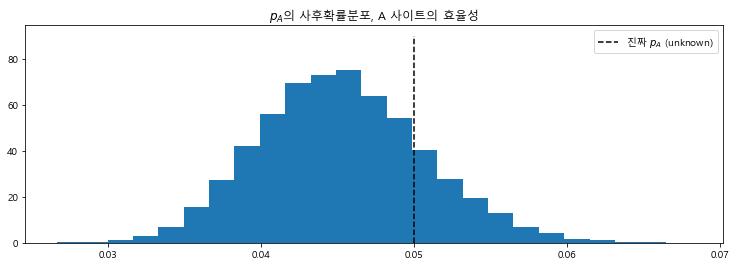

In [13]:
figsize(12.5, 4)
plt.title("$p_A$의 사후확률분포, A 사이트의 효율성")
plt.vlines(p_true, 0, 90, linestyle="--", label="진짜 $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend()

- 우리의 사후확률분포는 데이터가 제시하는 진짜 $P_A$값 주변에 가중치를 둠. 분포의 키가 클수록 가능성이 더 커짐. 관측치 N의 수를 변경하고 사후확률분포가 어떻게 변하는지 관측

### 2.2.4. A와 B를 묶어보기
- B 사이트의 데이터로 비슷한 분석을 수행하면 $P_B$의 사후확률분포를 알 수 있음. 우리가 정말로 궁금한건 $P_A$와 $P_B$의 차이.
- 그리고 delta = 0.01, $N_B$ = 750($N_A$의 절반), 그리고 A 사이트에서 했던 것 처럼 B 사이트도 시뮬레이션 진행

In [14]:
figsize(12, 4)

# 다음 둘은 미지수
true_p_A = 0.05
true_p_B = 0.04

# 표본의 크기는 다르지만 베이지안 분석에서는 문제가 되지 않음
N_A = 1500
N_B = 750

# 관측치 생성
observation_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observation_B = stats.bernoulli.rvs(true_p_B, size=N_B)

In [15]:
observation_A.mean()

0.03933333333333333

In [16]:
observation_B.mean()

0.034666666666666665

In [17]:
# pymc3 모델 설정. p_A와 p_B는 uniform 사전확률로 가정
with pm.Model() as model:
    p_A = pm.Uniform('P_A', 0, 1)
    p_B = pm.Uniform('P_B', 0, 1)
    
    # deterministic delta function 정의.
    delta = pm.Deterministic('delta', p_A - p_B)
    
    # 관측치 설정. 이 경우 관측 데이터셋이 두개 있음
    obs_A = pm.Bernoulli('obs_A', p_A, observed=observation_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed=observation_B)
    
    # 3장에서 설명
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]

<ipython-input-17-0c6ab3fdf732>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(20000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [P_B]
>Metropolis: [P_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 564 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [18]:
p_A_samples = burned_trace['P_A']
p_B_samples = burned_trace['P_B']
delta_samples = burned_trace['delta']

C:\Users\user\anaconda3\envs\test\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\envs\test\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


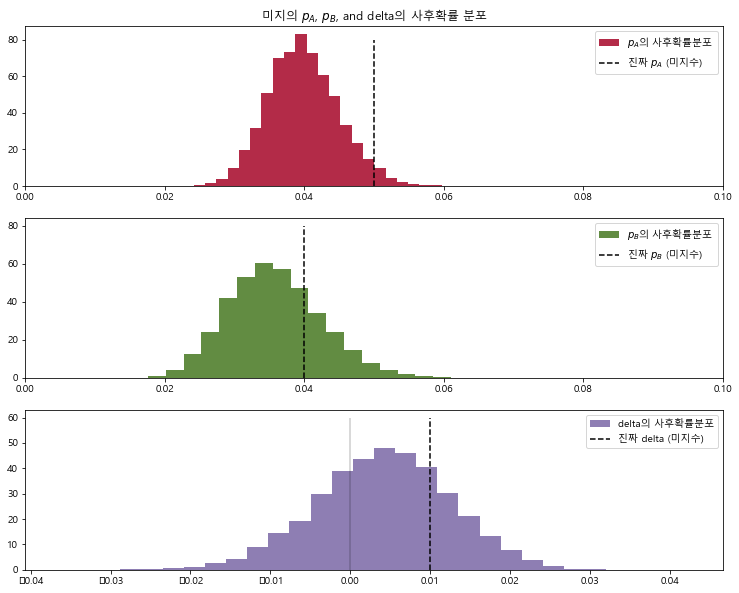

In [19]:
figsize(12.5, 10)

#histogram of posteriors
ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85, label="$p_A$의 사후확률분포", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="진짜 $p_A$ (미지수)")
plt.legend(loc="upper right")
plt.title("미지의 $p_A$, $p_B$, and delta의 사후확률 분포")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85, label="$p_B$의 사후확률분포", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="진짜 $p_B$ (미지수)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85, label="delta의 사후확률분포", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--", label="진짜 delta (미지수)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

- $P_B$의 사후확률분포가 $P_A$보다 평평한데, 이는 (데이터가 적어서) 확신이 부족하기 때문

### 2.2.5. 거짓말에 대한 알고리즘
- 사람들이 항상 정직하게 답변하는 것이 아니며 이는 추론을 더 복잡하게 만듦.
- 솔직하지 못한 답변 문제를 우회하는 해결책을 제시하기하는 베이지안 모델링을 위해 이항분포를 알아야 함(이항분포는 패스)
- N=1일때 이항분포는 베르누이분포가 됨.


- 이항분포를 사용하여 학생들이 시험 중에 부정행위를 저지르는 빈도를 알아낼 것.
- 시험을 치른 총 학생수를 N으로 놓고, 각 학생을 인터뷰한다면(처벌없음) 정숫값 X에 대해 부정행위 답변을 얻음.
- 그렇게 주어진 N,p 에 대한 일부 정해진 사전분포, 관찰된 데이터 X를 알면 우리는 p의 사후확률분포를 얻을 수 있음.


- 그러나 사실, 처벌이 없다 해도 부정행위를 인정하는 학생은 없을 것. 학생들이 부정행위를 했는지 물어볼 더 나은 알고리즘이 필요함.
    - 학생들은 인터뷰할 때 각자 숨겨둔 동전을 하나 던짐(인터뷰하는 사람은 몰라야 함)
    - 동전의 앞면이 나오는 경우: 정직하게 말할 것을 약속
    - 뒷면이 나오는 경우: 한번 더 던짐
        - 한번 더 던져서 앞면: 부정행위 했다고 얘기함
        - 한번 더 던져서 뒷면: 부정행위 안했다고 얘기함
- 위 프로세스는 모델링 될 수 있음. pymc를 활용하여 노이즈가 있는 모델을 조사할 수 있고, 거짓말쟁이의 진짜 빈도에 대한 사후확률분포를 알 수 있음


- 100명을 조사하는 경우, 부정행위 비율 p를 찾으려 함. 가장 명확한 방법 이후, 간소화된 버전으로 확인해볼 것
- p에 대해 전혀 모르므로 p의 사전확률로 Uniform(0, 1)을 부여함

In [20]:
N = 100

with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)

- 1은 부정행위 한거, 0은 안한거

In [21]:
with model:
    true_answer = pm.Bernoulli('truths', p, shape=N, testval=np.random.binomial(1, 0.5, N))

- 첫번째 단계로 동전던지기를 수행함. 이는 p=1/2인 베르누이 모델을 샘플링함. 1을 앞면, 0을 뒷면으로 봄

In [22]:
with model:
    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

In [23]:
first_coin_flips.tag.test_value

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1], dtype=int64)

- 비록 모두가 두번째 동전을 던지는 것은 아니지만, 두번째 동전 던지기에서 가능한 결과를 모델링 가능함

In [24]:
with model:
    second_coin_flips = pm.Bernoulli('second_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

- 이 변수를 사용해서 'yes' 답변이 과측된 비율의 결과추정치를 얻을 수 있음. pymc3의 deterministic 변수 사용

In [25]:
import theano.tensor as tt

with model:
    val = first_coin_flips*true_answer+(1-first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic('observed_propotion', tt.sum(val)/float(N))

- `첫번째던지기*참대답+(1-첫번째코인)*두번째던지기`는 프라이버시 알고리즘의 핵슴을 포함함
- 이때 필요충분조건은 1) 첫번째 동전을 던져 앞면이 나오고 학생이 치팅을 한 경우, 2) 첫번째 동전을 던져 뒷면이 나오고 두번째 동전을 던져 앞면이 나온 경우 외의 경우는 0임
- 마지막줄은 이 벡터를 합산하고 float(N)으로 나누어 비율을 생성함

In [26]:
observed_proportion.tag.test_value

array(0.49)

- 마지막으로, 데이터 셋이 필요함. 인터뷰가 끝나고 연구자들은 '예' 답변을 35개 얻었음. 이것으로 상대적인 평가를 한다고 했을 때, 부정행위자가 정말로 없다면 모든 대답 중 평균 1/4이 '예'가 되어야 함
- 반면에, 모든 학생이 부정행위를 했다면 모든 대답 중 약 3/4가 '예'가 되어야 함


- 연구자들은 N=100이고, value=35인 p=observed_proportion 이항확률변수를 관찰함

In [27]:
X=35

with model:
    observations = pm.Binomial('obs', N, observed_proportion, observed=X)

- 이후 아래 모델 실행

In [28]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

<ipython-input-28-63bf99e87614>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(40000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 79174 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [29]:
model

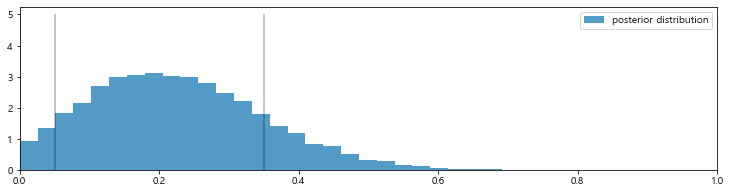

In [30]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

- 부정행위의 빈도를 여전히 확신할 수 없지만, 진짜 확률이 0.05에서 0.35 사이로 좁혀짐(실선)
- 사전확률을 확신할 수 없었기(이 때문에 사전확률로 uniform 분포를 사용함) 때문에, 의미가 있음.
- 반면에 나쁜 면도 있는데, '0.3'이라는 범위 내에 참 값이 존재할 가능성이 있기 때문.


- 사후확률에 딸면 부정행위자가 없다. 즉, p=0에 낮은 확률을 부여하는데 이는 믿기 어려움.
- uniform 분포로 사전확률을 정의했기 때문에, 모든 값을 동일하게 타당한 값으로 취급하고 있지만 잠재적으로 p=0을 배제하므로 부정행위가 있었다고 확신할 수 있음.


- 이런 종류의 알고리즘은 사용자의 개인정보를 수집하는데 사용될 수 있고, 노이즈가 있더라도 데이터가 진실하다는 것을 합리적으로 확신 가능.

### 2.2.6. PyMC3 대안 모델
- p 값이 주어진다면(현실에선 불가능하지만) 학생들이 '예'라고 대답할 확률을 다음과 같이 구할 수 있음
$$P("YES")=P(첫~동전의~앞면)P(부정행위자) + P(뒷~동전의~앞면)P(두~번째~동전의~앞면)\\ =\frac 1 2 p + \frac 1 2 \frac 1 2 \\ =\frac p 2 + \frac 1 4$$


- 따라서 p를 알고 있따면 우리는 한 학생이 '예'라고 대답할 확률을 안하. p로 deterministic 함수를 만들어서 확률 계산 가능

In [31]:
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)

- '예' 응답 35개를 담았음. pm.Binomial 선언에서 value=35와 observed=True 입력

In [32]:
with model:
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=35)

In [33]:
with model:
    # To Be Explained in Chapter 3!
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    burned_trace = trace[2500:]

<ipython-input-33-94070bb2a10b>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(25000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [freq_cheating]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 64 seconds.
The number of effective samples is smaller than 25% for some parameters.


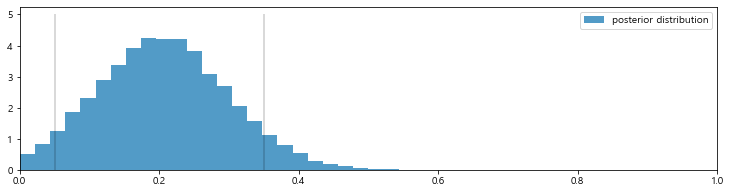

In [34]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

### 2.2.7. 더 많은 PyMC3 기법들
- numpy 배열에 다양한 종류의 pymc3 변수 저장 가능. numpy 배열을 초기화할 때 배열의 dtype을 object로 설정하면 됨.

In [38]:
N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential(f'x_{i}', (i+1.0**2))
        print(x[i])

x_0 ~ Exponential
x_1 ~ Exponential
x_2 ~ Exponential
x_3 ~ Exponential
x_4 ~ Exponential
x_5 ~ Exponential
x_6 ~ Exponential
x_7 ~ Exponential
x_8 ~ Exponential
x_9 ~ Exponential
